# Import necessary modules

### Numpy: 
    NumPy is the core library for scientific and numerical computing in Python. It provides high-performance 
    multidimensional array object and tools for working with arrays. In NumPy, ‘Arrays’ dimensions are called Axes.

### DLib: 
    Dlib is a modern C++ toolkit containing machine learning algorithms and tools for creating complex software in C++ to 
    solve real world problems. It is used in both industry and academia in a wide range of domains including robotics, 
    embedded devices, mobile phones, and large high performance computing environments.
#### Dlib is principally a C++ library, however, you can use a number of its tools from python applications using Python API.

### cv2:
    a module in OpenCV library which is used in many computer-vision applications
    
### matplotlib.pyplot
    - Matplotlib is designed to be as similar to MATLAB, with the ability to use Python. 'pyplot' function makes some change to a figure we input (creating a figure, creating a plotting area in a figure, plots some lines in a plotting area, etc.)
    
    - rcParams is used to size the output image by pyplot function

In [95]:
# import the necessary packages
import numpy as np
import dlib
import cv2
import matplotlib.pyplot as plt
from matplotlib import rcParams

## 1. Read the image
    - Read the image
    - choose the type of blur you want
    - Make sure you store the image height and weight

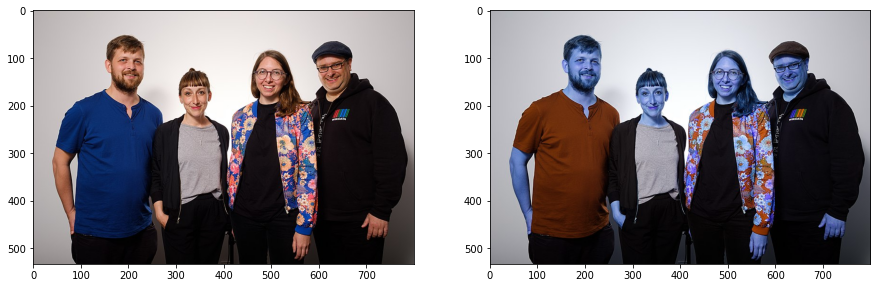

In [96]:
# step1: load the input image from disk, clone it, and grab the image spatial dimensions

image = cv2.imread("grp_face.jpg")
pixelate_image = False
(h, w) = image.shape[:2]

# make a copy of the image so it 
orig_copy = image.copy()

# the image is in BGR format change to RGB format to view it
orig_copy = cv2.cvtColor(orig_copy, cv2.COLOR_BGR2RGB)


_, ax = plt.subplots(1,2)
ax[0].imshow(orig_copy)
ax[1].imshow(image)

## 2. Convert the image channel from BGR to Gray Scale
    - the read image from step-1 is in BGR channel
    - for the image to be detected by HOG detector, the image should be in Gray Scale
    - so let's convert the image to Gray scale, using "cv2.cvtColor()" function

In [97]:
#step2: converts to gray image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

## 3. [HOG face detector](http://dlib.net/python/#dlib.get_frontal_face_detector)
    - dlib.get_frontal_face_detector()  => this returns the default HOG style feature extraction,
        ref: click the heading to go to the documentation of dlib
        
    - here hogFaceDetector(gray_scale_image, rqd_upscaling), takes in the gray scale image and the upscaling required

In [98]:
#step3: get HOG face detector and faces

hogFaceDetector = dlib.get_frontal_face_detector()
faces = hogFaceDetector(gray, 1)

## 4. Function to blur the faces

    - 'image' in the arguments refers to, the Region of Interest(ROI) - the faces we detect extract from HOG-detector

### a)
    - We use the GaussianBlur() in cv2 module to blur the faces (ROI):
    
     in GaussianBlur the arguments we input is the image, the kernel size (tuple of only POSITIVE and ODD integers)
     and the standard Gaussian standard deviation in X-direction ( this refers to mathematical aspect of computer vision, 
     which is beyond the scope of this workshop)

In [99]:
def blur_face_simple(image, blur_intensity=3.0):
    # automatically determine the size of the blurring kernel based
    # on the spatial dimensions of the input image
    (h, w) = image.shape[:2]
    kW = (w // blur_intensity)
    kH = (h // blur_intensity)

    # ensure the width of the kernel is odd
    if kW % 2 == 0:
        kW -= 1

    # ensure the height of the kernel is odd
    if kH % 2 == 0:
        kH -= 1

    # apply a Gaussian blur to the input image using our computed
    # kernel size
    return cv2.GaussianBlur(image, (kW, kH), 0)

## 4. Function to blur the faces

### b)
    - To pixelate the faces let's use the below function:
        - using numpy 'linspace' we can space the image(ROI) into evenly spaced intervals
        - then loop over the image in these evenly spaced intervals
        - draw a rectangle over each interval and making blocks of equal size
        - fill entire rectangle with the mean BGR values of all pixels in the original image

In [100]:
def blur_face_pixelate(image, blocks=3):
    # divide the input image into NxN blocks
    (h, w) = image.shape[:2]
    xSteps = np.linspace(0, w, blocks + 1, dtype="int")
    ySteps = np.linspace(0, h, blocks + 1, dtype="int")

    # loop over the blocks in both the x and y direction
    for i in range(1, len(ySteps)):
        for j in range(1, len(xSteps)):
            # compute the starting and ending (x, y)-coordinates
            # for the current block
            startX = xSteps[j - 1]
            startY = ySteps[i - 1]
            endX = xSteps[j]
            endY = ySteps[i]

            # extract the ROI using NumPy array slicing, compute the
            # mean of the ROI, and then draw a rectangle with the
            # mean RGB values over the ROI in the original image
            roi = image[startY:endY, startX:endX]
            (B, G, R) = [int(x) for x in cv2.mean(roi)[:3]]
            cv2.rectangle(image, (startX, startY), (endX, endY), (B, G, R), -1)

    # return the pixelated blurred image
    return image

## 5. Change the detected faces using the above defined functions

    - Now go through each face in the detected 'faces' of step 3,
        - send each face through above defined functions to blur each face
        - the functions change the face-part(ROI)
        - reassign the returned face from function to original image

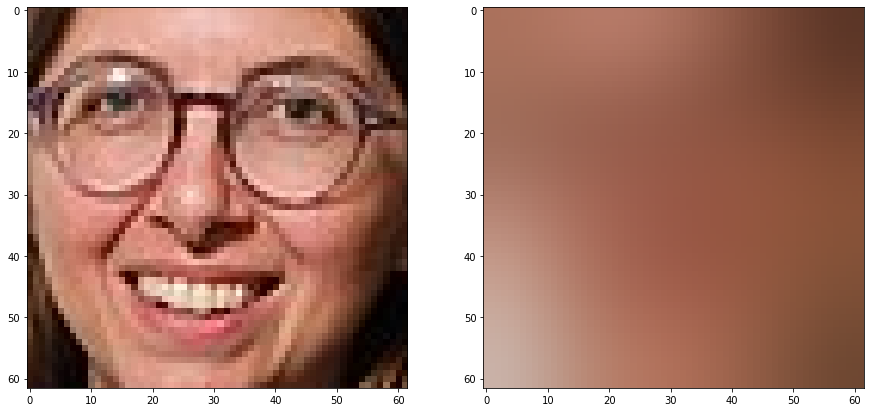

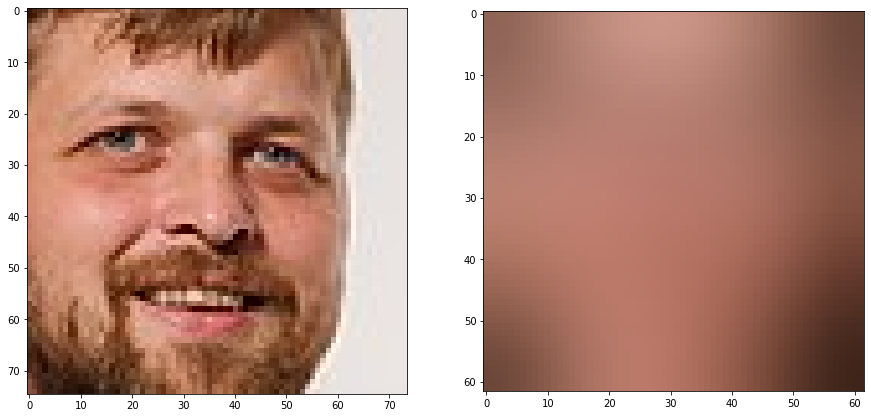

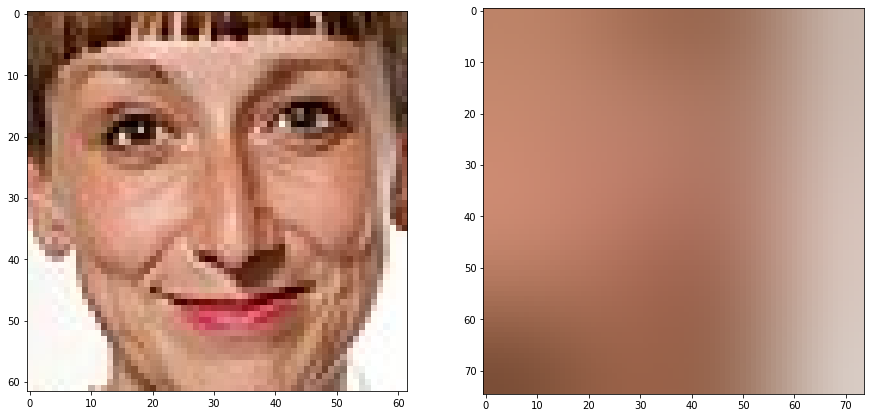

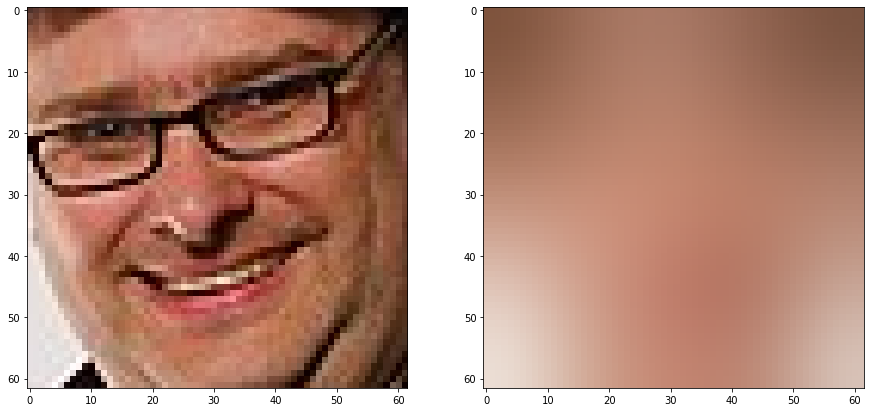

In [101]:
pixelate_image = False

#step4: loop through each face and draw a rect around it
for (i, rect) in enumerate(faces):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    startX, startY = x, y
    endX = x+w
    endY = y+h
    cut_face = image[startY:endY, startX:endX]
    #print(image.shape, startY, endY, startX, endX)
    #print(face.shape[:])
    orig_face = image[startY:endY, startX:endX]
    _, ax = plt.subplots(1,2)
    ax[0].imshow(cv2.cvtColor(orig_face,cv2.COLOR_BGR2RGB))
    ax[1].imshow(cv2.cvtColor(modified_face,cv2.COLOR_BGR2RGB))
    if pixelate_image:
        modified_face = blur_face_pixelate(cut_face, blocks=3)
    else:
        modified_face = blur_face_simple(cut_face, blur_intensity=1)
    image[startY:endY, startX:endX] = modified_face

62 62


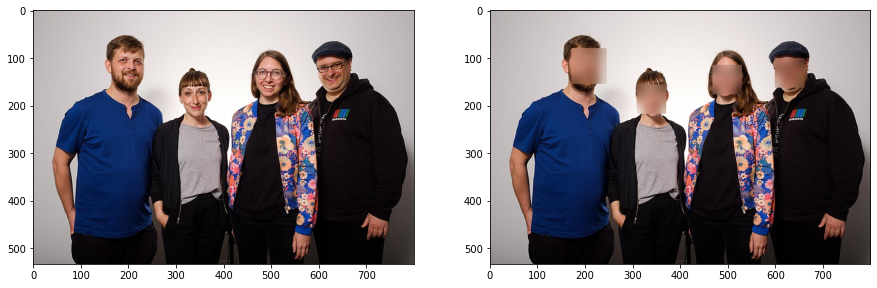

In [102]:
# display the original image and the output image with the blurred
# face(s) side by side
print(h,w)
output = np.hstack([orig_copy, image])
output = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# figure size in inches optional
rcParams['figure.figsize'] = 15 ,12

_, ax = plt.subplots(1,2)
ax[0].imshow(orig_copy);
ax[1].imshow(output);

#plt.imshow(orig,output)
#cv2.waitKey(0)

### Awesome, you've just learned something new!! Try something yourself and just keep learning!!!